In [53]:
import pandas as pd
import numpy as np

from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format

In [57]:
train = pd.read_csv("train.csv")

In [58]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [59]:
train.describe(include=[object])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [60]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [61]:
cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [43]:
# for col in cat_cols:
#     train[col].fillna("blank", inplace=True)
#     train[col] = train[col].astype("category")

In [44]:
# for col in num_cols:
#     train[col].fillna(0, inplace=True)

In [62]:
train = train[cat_cols+num_cols+["Transported"]]
# train.info()

In [63]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [50]:
for col in num_cols:
    if col != "Age":
        train[col] = np.log(train[col]+1)

In [52]:
train.head()

,HomePlanet,CryoSleep,Destination,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,False,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,False
1,Earth,False,TRAPPIST-1e,False,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,True
2,Europa,False,TRAPPIST-1e,True,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,False
3,Europa,False,TRAPPIST-1e,False,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,False
4,Earth,False,TRAPPIST-1e,False,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,True


In [71]:
dls = TabularPandas(
    train, splits=RandomSplitter()(train),
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cat_cols,
    cont_names=num_cols,
    y_names="Transported", y_block = CategoryBlock(),
).dataloaders(path=".")

In [72]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10,10])

SuggestedLRs(slide=0.04786301031708717, valley=0.002511886414140463)

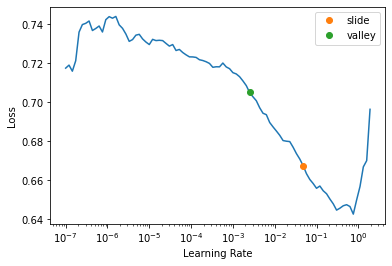

In [73]:
learn.lr_find(suggest_funcs=(slide, valley))

In [74]:
learn.fit(20, lr=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.479892,0.455732,0.765823,00:00
1,0.468085,0.445406,0.783084,00:00
2,0.458931,0.459270,0.769275,00:00
3,0.451573,0.454439,0.779632,00:00
4,0.461011,0.450213,0.779632,00:00
5,0.447822,0.463937,0.765247,00:00
6,0.462453,0.454044,0.772727,00:00
7,0.459209,0.474639,0.768700,00:00
8,0.459235,0.464752,0.788262,00:00
9,0.454724,0.449317,0.782509,00:00


In [75]:
tst_df = pd.read_csv("test.csv")
tst_dl = learn.dls.test_dl(tst_df)

In [76]:
preds,_ = learn.get_preds(dl=tst_dl)
preds

tensor([[0.3879, 0.6121],
        [0.9687, 0.0313],
        [0.0503, 0.9497],
        ...,
        [0.1456, 0.8544],
        [0.3011, 0.6989],
        [0.4028, 0.5972]])

In [78]:
tst_df['Transported'] = (preds[:,1]>0.5)
sub_df = tst_df[['PassengerId','Transported']]
sub_df.to_csv('sub.csv', index=False)